<a href="https://colab.research.google.com/github/lauracmh/Robot-Trading/blob/main/Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Challenge 1: Robot Trading [Bootcamp Data Science]

## 1. Configuación de ambiente

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
import requests

In [245]:
#definiendo variables globales
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

##2. Obtención de datos

In [246]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, precio, variacion
  btc = yf.Ticker("BTC-USD")
  df_bitcoin = btc.history(interval= '5m', period='7d')

In [247]:
def extraer_tendencias():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision, precio, variacion
  headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'}
  url = 'https://coinmarketcap.com/'
  respuesta = requests.get(url, headers=headers)

  s = BeautifulSoup(respuesta.text, "html.parser")

  precio = s.find('a',{'href':'/currencies/bitcoin/#markets'}).getText()
  precio_actual = float(precio.replace('$','').replace(',',''))

  variacion = s.find('a',{'href':'/currencies/bitcoin/#markets'}).find_next('td')

  if 'icon-Caret-up' in str(variacion):
    tendencia = 'alta'
  elif 'icon-Caret-down'in str(variacion):
    tendencia = 'baja'

  variacion = variacion.getText()

  #print(f'precio: {precio}, precio: {precio_actual}, variación: {variacion}, tendencia: {tendencia}')


##3. Limpieza de Datos

In [248]:
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  #crear copia del df
  df_bitcoin_limpio = df_bitcoin.copy()
  df_bitcoin_limpio = df_bitcoin_limpio.reset_index()

  #Eliminar duplicados
  if df_bitcoin_limpio.Datetime.is_unique == False:
    df_bitcoin_limpio = df_bitcoin_limpio.drop_duplicates()

  #Tratar datos nulos
  if df_bitcoin_limpio.Close.isnull().sum() >0:
    df_bitcoin_limpio.Close.fillna(method='bfill')

  #Filtrar Volumen>0
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume']> 0]

  #eliminar outliers en el precio de cierre
  #df_bitcoin_limpio.boxplot('Close')
  #IQR: rango intercuartil
  Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  IQR = Q3 - Q1
  filtro = (df_bitcoin_limpio['Close'] >= Q1 - 1.5 * IQR) & (df_bitcoin_limpio['Close'] <= Q3 + 1.5 *IQR)
  df_bitcoin_limpio = df_bitcoin_limpio[filtro]

  #seleccionar valores entre Q1 y Q3
  filtro2 = (df_bitcoin_limpio['Close']>=Q1) & (df_bitcoin_limpio['Close']<=Q3)
  media_bitcoin = df_bitcoin_limpio[filtro2]['Close'].mean()


##4. Tomar decisiones

In [249]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  if (precio_actual >= media_bitcoin) and (tendencia=='baja'):
    algoritmo_decision = 'Vender'
  elif (precio_actual < media_bitcoin) and (tendencia=='alta'):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'


##5. Visualización

In [250]:
from typing_extensions import Annotated
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  df_bitcoin['Promedio'] = media_bitcoin

  t = '\u25b4' if tendencia=='alta' else '\u25be'
  color = 'green' if tendencia=='alta' else 'red'

  x = df_bitcoin.index
  y1 = df_bitcoin['Close']
  y2 = df_bitcoin['Promedio']
  plt.figure(figsize=(16,5))
  plt.plot(x,y1, label = "Precio de cierre")
  plt.plot(x,y2, label = "Precio Promedio")
  plt.xlabel("Fecha")
  plt.ylabel("Precio BTC/USD")
  plt.legend()
  plt.annotate(algoritmo_decision,xy=(x[-5],y1.min()),bbox=dict(boxstyle="square", fc= "lightsteelblue"), size=15)
  plt.annotate("$%.2f" %media_bitcoin,xy=(x[-1],media_bitcoin),bbox=dict(boxstyle="square", fc= "coral"), size=10)
  plt.title("$\mathbf{Bitcoin}$"+" " +"$\mathbf{BTC}$\n", fontsize = "20", y=1.02, x=0.07)
  title = plt.title(f'{precio} ', fontsize = "25", loc= "left")
  plt.annotate(f'{t}{variacion}', fontsize = "20", color=color, xycoords=title, xy=(1, 0.2))
  plt.show()


##6. Automatización

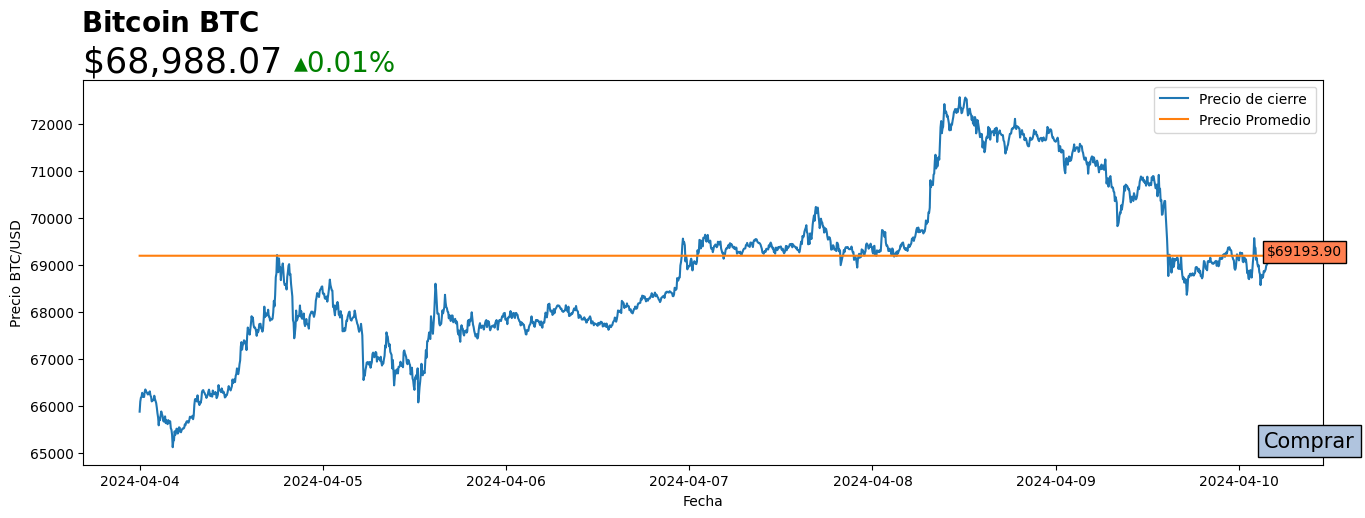

KeyboardInterrupt: 

In [251]:
from IPython.display import clear_output
import time

while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(60)